# Preparation

In [1]:
# !mkdir t5_model
# !mkdir data
# !pip install transformers
# !pip install sentencepiece
# !pip install tf-models-official


In [2]:
import os
import pandas as pd
from transformers import T5Tokenizer, BertTokenizer, TFT5ForConditionalGeneration, TFBertForSequenceClassification, T5Config
import tensorflow as tf

2023-02-07 23:27:37.542716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 23:27:38.241249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-07 23:27:38.241299: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-07 23:27:38.241305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Data Import and Preprocess
## Download data files from kaggle
https://www.kaggle.com/c/nlp-getting-started

In [3]:
train_df = pd.read_csv('data/train.csv')

In [4]:
EXAMPLE_SIZE = train_df.shape[0]

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df.text.tolist()[:5]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']

In [8]:
train_df = train_df.drop(['id', 'keyword', 'location'], axis=1)
train_df = train_df.rename(columns={"text": "input_ids", "target": "labels"})

In [9]:
train_df['labels'] = train_df.labels.map(lambda x : 'positive' if x == 1 else 'negative')

In [10]:
TASK_PREFIX = 'DisasterTweets: '
train_df['input_ids'] = train_df.input_ids.map(lambda x : TASK_PREFIX + x)

In [11]:
train_df.head()

,input_ids,labels
0,DisasterTweets: Our Deeds are the Reason of th...,positive
1,DisasterTweets: Forest fire near La Ronge Sask...,positive
2,DisasterTweets: All residents asked to 'shelte...,positive
3,"DisasterTweets: 13,000 people receive #wildfir...",positive
4,DisasterTweets: Just got sent this photo from ...,positive


In [12]:
train_df[train_df['labels']=='positive']

,input_ids,labels
0,DisasterTweets: Our Deeds are the Reason of th...,positive
1,DisasterTweets: Forest fire near La Ronge Sask...,positive
2,DisasterTweets: All residents asked to 'shelte...,positive
3,"DisasterTweets: 13,000 people receive #wildfir...",positive
4,DisasterTweets: Just got sent this photo from ...,positive
...,...,...
7608,DisasterTweets: Two giant cranes holding a bri...,positive
7609,DisasterTweets: @aria_ahrary @TheTawniest The ...,positive
7610,DisasterTweets: M1.94 [01:04 UTC]?5km S of Vol...,positive
7611,DisasterTweets: Police investigating after an ...,positive


In [13]:
train_df[train_df['labels']=='negative']

,input_ids,labels
15,DisasterTweets: What's up man?,negative
16,DisasterTweets: I love fruits,negative
17,DisasterTweets: Summer is lovely,negative
18,DisasterTweets: My car is so fast,negative
19,DisasterTweets: What a goooooooaaaaaal!!!!!!,negative
...,...,...
7581,DisasterTweets: @engineshed Great atmosphere a...,negative
7582,DisasterTweets: Cramer: Iger's 3 words that wr...,negative
7584,DisasterTweets: These boxes are ready to explo...,negative
7587,DisasterTweets: Sirens everywhere!,negative


<AxesSubplot: >

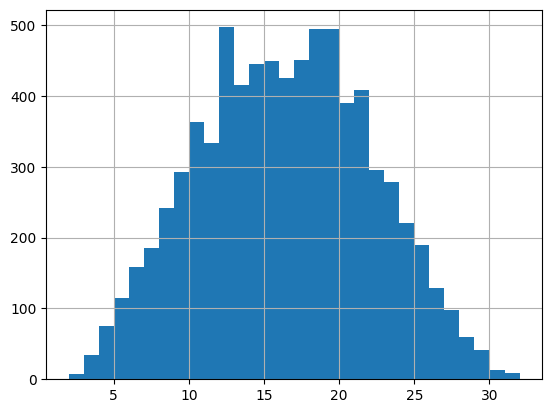

In [14]:
#training tweets length histogram
# max len is 500 (y axis), as twitter limits the tweets to 500 long.
tweet_len = [len(i.split()) for i in train_df.input_ids]
pd.Series(tweet_len).hist(bins = 30)

<AxesSubplot: >

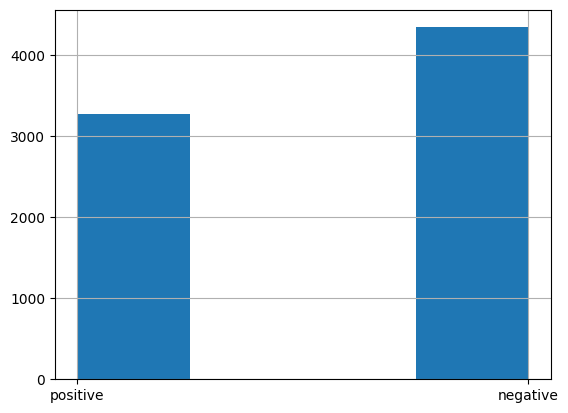

In [15]:
# label class distribution
pd.Series(train_df.labels).hist(bins = 4)

# Prepare tokenizer and tokenize the input

In [16]:
T5_MODEL_VER = 0
t5_model_variants = ("t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b")
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_variants[T5_MODEL_VER])
#t5_tokenizer = T5Tokenizer(tokenizer_file='/content/t5-v1_1-small/tokenizer_config.json')

/home/kevin/miniconda3/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [17]:
in_batch_encoding = t5_tokenizer(train_df['input_ids'].tolist(), padding=True, return_tensors="tf")
targ_batch_encoding = t5_tokenizer(train_df['labels'].astype(str).tolist(),  max_length=2, return_tensors="tf")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [18]:
te = targ_batch_encoding['input_ids'][22]
t5_tokenizer.decode(te)

'negative</s>'

In [19]:
import tensorflow as tf
# construct tf dataset that t5 model can input
ds_train = tf.data.Dataset.from_tensor_slices({'input_ids' : in_batch_encoding.input_ids,
                             'attention_mask' : in_batch_encoding.attention_mask,
                              'labels' : targ_batch_encoding.input_ids,
                              'decoder_attention_mask' : targ_batch_encoding.attention_mask})

In [20]:
# split train/val set
def split_dataset(ds, ds_size, val_split=0.1):
    #ds_size = tf.data.experimental.cardinality(train_ds).numpy()
    train_size = int((1 - val_split) * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds
# prefetch, shuffle and batch the dataset
def dataset_prepare(dataset, batch_size=32, training=True):
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(1*1024)
    dataset = dataset.batch(batch_size)
    return dataset

In [21]:
dataset = dataset_prepare(ds_train)
ds_train, ds_val = split_dataset(dataset, EXAMPLE_SIZE)

In [22]:
# peek the dataset
aaa = iter(ds_train)
bbb= next(aaa)
print(bbb)

{'input_ids': <tf.Tensor: shape=(32, 113), dtype=int32, numpy=
array([[29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0],
       ...,
       [29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 113), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(32, 2), dtype=int32, numpy=
array([[2841,    1],
       [1465,    1],
       [2841,    1],
       [2841,    1],
       [1465,    1],
       [2841,    1],
       [2841,    1],
       [2841,    1],
       [2841,    1],
       [1465,    1],
       [2841,    1]

In [23]:
print(t5_tokenizer.decode(bbb['input_ids'][3]))
#print(t5_tokenizer.decode(bbb['input_ids'][3], skip_special_tokens=False))
#bbb['attention_mask'][3]
#print(len(bbb['labels'][3]))
print(t5_tokenizer.decode(bbb['labels'][3], skip_special_tokens=False))
#bbb['labels'][3]

DisasterTweets: 'I can't have kids cuz I got in a bicycle accident &amp; split my testicles. it's impossible for me to have kids' MICHAEL YOU ARE THE FATHER</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
negative</s>


# Prepare model


TensorFlow models and layers in transformers accept two formats as input:

having all inputs as keyword arguments (like PyTorch models), or
having all inputs as a list, tuple or dict in the first positional argument.
The reason the second format is supported is that Keras methods prefer this format when passing inputs to models and layers. Because of this support, when using methods like model.fit() things should “just work” for you - just pass your inputs and labels in any format that model.fit() supports! If, however, you want to use the second format outside of Keras methods like fit() and predict(), such as when creating your own layers or models with the Keras Functional API, there are three possibilities you can use to gather all the input Tensors in the first positional argument:

a single Tensor with input_ids only and nothing else: model(input_ids)
a list of varying length with one or several input Tensors IN THE ORDER given in the docstring: model([input_ids, attention_mask]) or model([input_ids, attention_mask, token_type_ids])
a dictionary with one or several input Tensors associated to the input names given in the docstring: model({"input_ids": input_ids, "token_type_ids": token_type_ids})
Note that when creating models and layers with subclassing then you don’t need to worry about any of this, as you can just pass inputs like you would to any other Python function!

In [24]:
# from_pretrained method will download and cache the model
# TFT5ForConditionalGeneration is a huggingface T5 Model with a language modeling head on top.
# CLM (causal language model, autoregresive means the same thing)
t5_model = TFT5ForConditionalGeneration.from_pretrained(t5_model_variants[T5_MODEL_VER])

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [25]:
##### import os
import numpy as np
import tensorflow as tf
from official.nlp import optimization
import datetime

# epochs = 20
epochs = 2
batch_size = 32
init_lr = 1e-4

steps_per_epoch = 1406
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10


optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')
#optimizer = tf.keras.optimizers.Adam(init_lr)

#metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')]

t5_model.compile(optimizer=optimizer, loss='passthrough')

checkpoint_filepath = 't5_model'
t5_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

log_dir = 'tensorboard'
start_profile_batch = steps_per_epoch + 10
stop_profile_batch = start_profile_batch + 100
#profile_range = f"{start_profile_batch},{stop_profile_batch}"
log_path = log_dir + "/t5/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
t5_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                #profile_batch=profile_range,
                                                update_freq=20)

t5_earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks = [t5_checkpoint, t5_tensorboard, t5_earlystop]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [26]:
history = t5_model.fit(
            x=ds_train,
            validation_data=ds_val,
            callbacks=callbacks,
            epochs=epochs)


Epoch 1/2
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


238/238 [==============================] - ETA: 0s - loss: 3.1283

2023-02-07 23:28:44.388362: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.
2023-02-07 23:28:45.315940: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.
2023-02-07 23:28:47.281541: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.


238/238 [==============================] - 63s 204ms/step - loss: 3.1283
Epoch 2/2
238/238 [==============================] - ETA: 0s - loss: 0.2447

2023-02-07 23:29:32.498953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.
2023-02-07 23:29:33.327753: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.


238/238 [==============================] - 48s 202ms/step - loss: 0.2447


In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
t5_model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60,506,624
Trainable params: 60,506,624
Non-trainable params: 0
_________________________________________________________________


In [29]:
inputs = t5_tokenizer("DisasterTweets: I went to see a doctor.", return_tensors="tf").input_ids 
#inputs = t5_tokenizer("summarize: I was hiking toward his isolated valley in the Hengduan Mountains when Yang drove up the steep trail on his motorcycle to greet me. I had arranged to stay at his family’s rustic guesthouse, which was a clutch of log cabins tucked among fallow fields of potatoes and wheat. Yang indeed looked manly in his brown leather coat and blue jeans. But if he seemed like any other typically rakish mountaineer in this rugged part of China, my introduction to his household told me differently. His home was occupied exclusively by women relatives. And Yang wasn’t only outnumbered. He was out-talked.", return_tensors="tf").input_ids 
#inputs = t5_tokenizer("cola: I would have been killing you", return_tensors="tf").input_ids 
#inputs = t5_tokenizer("sst2: i do enjoy wonderful", return_tensors="tf").input_ids
outputs = t5_model.generate(inputs)
print(t5_tokenizer.decode(outputs[0], skip_special_tokens=True))

/home/kevin/miniconda3/lib/python3.10/site-packages/transformers/generation/tf_utils.py:702: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


negative


In [30]:
# !mkdir t5_model_DisasterTweets
# t5_model.save('t5_model_DisasterTweets')

In [31]:
# t5_model = tf.saved_model.load('t5_model_DisasterTweets')

In [32]:
# CHECKPOINT_PATH = 't5_model/DisasterTweets'
# checkpoint = tf.train.Checkpoint(t5_model)
# save_path = checkpoint.save(CHECKPOINT_PATH)

In [33]:
# CHECKPOINT_PATH = 't5_model/DisasterTweets-1'
# checkpoint = tf.train.Checkpoint(t5_model)
# checkpoint.restore(CHECKPOINT_PATH)

# T5 Testing (batch prediction, for kaggle challenge submission)

In [57]:
test_df = pd.read_csv('data/test.csv')
TEST_EXAMPLE_SIZE = test_df.shape[0]
#TEST_EXAMPLE_SIZE = 1000
test_df.sort_values(by=['id'])
test_df = test_df.drop(['keyword', 'location'], axis=1)
test_df = test_df.rename(columns={"text": "input_ids"})
TASK_PREFIX = 'DisasterTweets: '
test_df['input_ids'] = test_df.input_ids.map(lambda x : TASK_PREFIX + x)
test_df


,id,input_ids
0,0,DisasterTweets: Just happened a terrible car c...
1,2,DisasterTweets: Heard about #earthquake is dif...
2,3,DisasterTweets: there is a forest fire at spot...
3,9,DisasterTweets: Apocalypse lighting. #Spokane ...
4,11,DisasterTweets: Typhoon Soudelor kills 28 in C...
...,...,...
3258,10861,DisasterTweets: EARTHQUAKE SAFETY LOS ANGELES ...
3259,10865,DisasterTweets: Storm in RI worse than last hu...
3260,10868,DisasterTweets: Green Line derailment in Chica...
3261,10874,DisasterTweets: MEG issues Hazardous Weather O...


In [58]:
#in_batch_encoding = t5_tokenizer(test_pd.input_ids.tolist()[:1000], padding=True, return_tensors="tf")
in_batch_encoding = t5_tokenizer(test_df.input_ids.tolist(), padding=True, return_tensors="tf")
ds_test = tf.data.Dataset.from_tensor_slices({'input_ids' : in_batch_encoding.input_ids,
                                                'attention_mask' : in_batch_encoding.attention_mask,
                                                'decoder_input_ids': tf.zeros((TEST_EXAMPLE_SIZE, 1), dtype=tf.int32),
                                                'decoder_attention_mask': tf.ones((TEST_EXAMPLE_SIZE, 1), dtype=tf.int32),})
ds_test = dataset_prepare(ds_test, training=False)
#the generate method of T5ForConditionalGeneration is more appropriate for generating a sentence.  We can just use 
#model.predict() since the expected outputs are expressed as a single token.  We just need to start the decoder_inputs with start token


<AxesSubplot: >

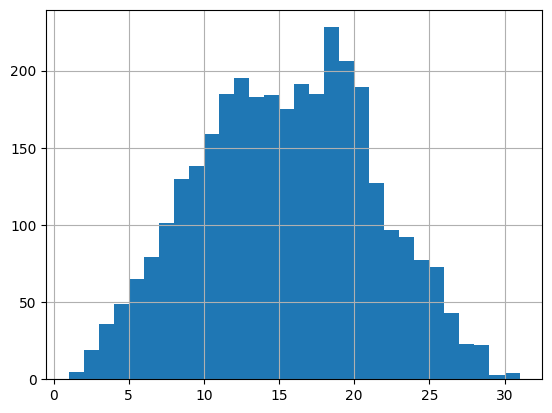

In [60]:
tweet_len = [len(i.split()) for i in test_pd.input_ids]
pd.Series(tweet_len).hist(bins = 30)

In [61]:
#running prediction on the whole test dataset will run out of memory
#use workaround, split test dataset into 3 portions
#test_ds1, test_ds2 = split_dataset(t5_dataset, TEST_EXAMPLE_SIZE, val_split=0.66)
#test_ds2, test_ds3 = split_dataset(test_ds2, TEST_EXAMPLE_SIZE, val_split=0.5)
#y_pred_ids = t5_model.predict(t5_dataset, verbose=1)

In [62]:
TEST_EXAMPLE_SIZE

3263

In [63]:
t5_tokenizer.convert_tokens_to_ids('<extra_id_1>')
print(t5_tokenizer.convert_tokens_to_ids('</s>'))
#print(t5_tokenizer.eos_token_id)
#t5_tokenizer.prefix
t5_config = T5Config()
t5_config.get_config_dict(t5_model_variants[T5_MODEL_VER])[0]['decoder_start_token_id']   

1


0

In [89]:
#T5ForConditionalGeneration.generate API doesn't support tensorflow dataset, so need to manually loop through

t5_result = []
for step, input_batch in enumerate(ds_test.take(5)):
    input_ids_batch = input_batch['input_ids']
    # print(step)
    # print(input_batch)
    #print(t5_tokenizer.decode(input_batch['input_ids'], skip_special_tokens=True))
    # print(input_batch.shape)

    pred_ids_batch = t5_model.generate(input_ids_batch)
    for idx, pred_ids in enumerate(pred_ids_batch):  # idx is index within a batch
      prediction = t5_tokenizer.decode(pred_ids, skip_special_tokens=True)
      input_ids = input_ids_batch[idx]
      input = t5_tokenizer.decode(input_ids, skip_special_tokens=True)
      t5_result.append(input + '----' + prediction)

2023-02-08 00:37:30.668238: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [84]:
aaa = iter(ds_test)
bbb = next(aaa)
print(bbb['input_ids'])
t5_tokenizer.decode(bbb['input_ids'][0], skip_special_tokens=True)

tf.Tensor(
[[29798   382  1123 ...     0     0     0]
 [29798   382  1123 ...     0     0     0]
 [29798   382  1123 ...     0     0     0]
 ...
 [29798   382  1123 ...     0     0     0]
 [29798   382  1123 ...     0     0     0]
 [29798   382  1123 ...     0     0     0]], shape=(32, 88), dtype=int32)


2023-02-08 00:28:17.723468: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


'DisasterTweets: Just happened a terrible car crash'

In [67]:
len(t5_result)

160

In [ ]:
t5_result

In [46]:
%load_ext tensorboard

In [47]:
log_dir='tensorboard/tb_bert'
%tensorboard --logdir {log_dir} --host localhost --port 8083

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.